In [94]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sp
from scipy.integrate import odeint
from numpy.linalg import inv
import pdb
import scipy.io
from scipy.stats.distributions import chi2

In [2]:
data_file = scipy.io.loadmat('../DATA/cooplocalization_finalproj_KFdata.mat')
data_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Apr  9 16:24:23 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Qtrue': array([[0.001, 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.001, 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.01 , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.001, 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.001, 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.01 ]]),
 'Rtrue': array([[2.25e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 6.40e+01, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 4.00e-02, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 3.60e+01, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 3.60e+01]]),
 'measLabels': array([[array(['\\gamma_{ag} (rads)'], dtype='<U18'),
         array(['\\rho_{ga} (m)'], dtype='<U13'),
         array(['\\gamma_{ga} (rads)'], dtype='<U18'),
         array(['\\xi_a (m)'], dtype='<U9'),
        

In [122]:
#Initializations

x0 = np.array([10,0,np.pi/2,-60,0,-np.pi/2]).reshape(6,1)
u = np.array([2, -np.pi/18, 12, np.pi/25])
L = 0.5
num_time_steps = 1000
num_mc_simulations = 1000
delta_t = 0.1
time_steps = data_file['tvec'].transpose().reshape(len(time_steps),)
Qtrue = data_file['Qtrue']
#cholesky_decomposition_Qtrue = np.linalg.cholesky(Qtrue)
Rtrue = data_file['Rtrue']
#cholesky_decomposition_Rtrue = np.linalg.cholesky(Rtrue)
plt.rcParams["figure.figsize"] = (15,15)

In [123]:
#Generate True data with noise

def model(x, t, u, noise, L):
    e_g = x[0]
    n_g = x[1]
    theta_g = x[2]
    e_a = x[3]
    n_a = x[4]
    theta_a = x[5]
    v_g = u[0]
    phi_g = u[1]
    v_a = u[2]
    w_a = u[3] 
    dxdt = [0]*6
    dxdt[0] = v_g*np.cos(theta_g) + noise[0][0]
    dxdt[1] = v_g*np.sin(theta_g) + noise[1][0]
    dxdt[2] = (v_g/L)*np.tan(phi_g) + noise[2][0]
    dxdt[3] = v_a*np.cos(theta_a) + noise[3][0]
    dxdt[4] = v_a*np.sin(theta_a) + noise[4][0]
    dxdt[5] = w_a + noise[5][0]
    return dxdt

def calculate_exact_yt(x,v):
    temptop = (x[4]-x[1])
    tempbot = (x[3]-x[0])
    y1 = np.arctan2(temptop,tempbot) - (x[2])
    if y1 < 0:
        y1 = y1 + 2*np.pi
    y1 = y1 - np.pi
    y2 = ( (x[0]-x[3])**2 + (x[1]-x[4])**2 ) ** 0.5
    y3 = np.arctan2(-temptop,-tempbot) - (x[5])
    if y3 < 0:
        y3 = y3 + 2*np.pi
    y4 = x[3]
    y5 = x[4]
    
    yt = np.array([
                [y1],
                [y2],
                [y3],
                [y4],
                [y5]
                ])
    yt = yt + v
    return yt

def get_sample_noise(S):
    n = len(S)
    std_normal_covar_matrix = np.identity(n)
    std_normal_mean_matrix = np.zeros(n)
    sampled_noise_with_covar_I = np.random.multivariate_normal(std_normal_mean_matrix, std_normal_covar_matrix).reshape(n,1)
    sampled_noise_with_covar_Q = np.dot(S,sampled_noise_with_covar_I)
    return sampled_noise_with_covar_Q

def wrap_in_negative_pi_to_pi(theta):
    wrapped_angle = (theta + np.pi) % (2 * np.pi) - np.pi
    return wrapped_angle

def get_Xtrue(x0,time_steps,cholesky_decomposition_Qtrue,L):
    Xtrue = [x0]
    n = len(x0)
    for i in range(1,len(time_steps)):
        w = get_sample_noise(cholesky_decomposition_Qtrue)
        xk = Xtrue[-1]
        xk_plus1 = odeint(model, xk.reshape(n,), np.linspace(0, 0.1, 2), args = (u,w,L))
        xk_plus1 = xk_plus1[-1]
        xk_plus1[2] = wrap_in_negative_pi_to_pi(xk_plus1[2])
        xk_plus1[5] = wrap_in_negative_pi_to_pi(xk_plus1[5])
        xk_plus1 = xk_plus1.reshape(n,1)
        Xtrue.append(xk_plus1)    
    return Xtrue

def get_Ytrue(Xtrue,cholesky_decomposition_Rtrue):
    Ytrue = []
    n = len(Xtrue[0])
    for i in range(0,len(Xtrue)):
        v = get_sample_noise(cholesky_decomposition_Rtrue)
        yk = calculate_exact_yt(Xtrue[i].reshape(n,),v)
        Ytrue.append(yk)    
    return Ytrue

# Xtrue = get_Xtrue(x0,time_steps,cholesky_decomposition_Qtrue,L)
# Ytrue = get_Ytrue(Xtrue,cholesky_decomposition_Rtrue)

In [124]:
#Jacobians

def get_CT_Jacobians(x,u,time_update_flag,measurement_update_flag):
    
    A = 0; B = 0; Ga = 0; C = 0; D = 0
    
    if(time_update_flag):    
        A = np.array([
                [0, 0, -u[0]*np.sin(x[2]), 0, 0, 0],
                [0, 0, u[0]*np.cos(x[2]), 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, -u[2]*np.sin(x[5])],
                [0, 0, 0, 0, 0, u[2]*np.cos(x[5])],
                [0, 0, 0, 0, 0, 0]])

        Ga = np.eye(6)
    
    if(measurement_update_flag):
    
        denominator_1 = 1 + ((x[4]-x[1])/(x[3]-x[0]))**2
        numerator_11 = (x[4]-x[1]) / ((x[3] - x[0])**2)
        C11 = numerator_11/denominator_1

        numerator_12 = -1/(x[3]-x[0])
        C12 = numerator_12/denominator_1

        C14 = -1*C11
        C15 = -1*C12

        denominator_2 = ( (x[0]-x[3])**2 + (x[1]-x[4])**2 ) ** 0.5
        C21 = (x[0]-x[3])/denominator_2
        C22 = (x[1]-x[4])/denominator_2
        C24 = -1*C21
        C25 = -1*C22

        C = np.array([
                [C11, C12, -1, C14, C15, 0],
                [C21, C22, 0, C24, C25, 0],
                [C11, C12, 0, C14, C15, -1],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0]
                ])
    
    return A,B, Ga, C, D

def get_DT_Jacobians(x,u,dt,time_update_flag,measurement_update_flag):
    
    A,B,Gamma,C,D = get_CT_Jacobians(x,u,time_update_flag,measurement_update_flag)
    F = 0; G = 0; Omega = 0; H = 0; M = 0
    if(time_update_flag):
        F = np.eye(6) + dt*A
        Omega = delta_t*Gamma
    if(measurement_update_flag):
        H = C
        M = D
    
    return F,G,Omega,H,M

In [125]:
#Extended Kalman Filter

def kf_time_update(xk,Pk,uk,Q):
    n = len(xk)
    noise = np.zeros(n).reshape(n,1)
    #Calculate Jacobians    
    Fk,Gk,Omegak,Hk,Mk = get_DT_Jacobians(xk.reshape(n,),uk,delta_t,True,False)
    #Calculate x(k+1) minus
    #Note x(k+1) minus is of shape (n,) (just one dimension)
    xk_propogated = odeint(model, xk.reshape(n,), np.linspace(0, 0.1, 2), args = (u,noise,L))
    xk_propogated = xk_propogated[-1]
    xk_propogated[2] = wrap_in_negative_pi_to_pi(xk_propogated[2])
    xk_propogated[5] = wrap_in_negative_pi_to_pi(xk_propogated[5]) 
    #Calculate P(k+1) minus
    Pk_propogated = np.dot(Fk,np.dot(Pk,Fk.transpose())) + np.dot(Omegak,np.dot(Q,Omegak.transpose()))
    
    return xk_propogated, Pk_propogated

def kf_measurement_update(xk_propogated,Pk_propogated,yk_observed,uk,R):
    p = len(yk_observed)
    #noise
    v = np.zeros(p).reshape(p,1)
    yk_predicted = calculate_exact_yt(xk_propogated,v)
    surprise_factor = yk_observed - yk_predicted
    #Calculate Jacobians
    Fk_plus1_minus,Gk_plus1_minus,Omegak_plus1_minus,Hk_plus1_minus,Mk_plus1_minus = get_DT_Jacobians(xk_propogated,uk,delta_t,False,True)
    #Calculate Kalman Gain
    fc_kalman_gain = np.dot(Pk_propogated,Hk_plus1_minus.transpose())
    sc_kalman_gain = np.dot(Hk_plus1_minus,np.dot(Pk_propogated,Hk_plus1_minus.transpose())) + R
    kalman_gain = np.dot(fc_kalman_gain,inv(sc_kalman_gain))
    #Calculate x(k+1) plus
    n = len(xk_propogated)
    xk_plus1 = xk_propogated.reshape(n,1) + np.dot(kalman_gain,surprise_factor)
    #Calculate P(k+1) plus
    (n,m) = Pk_propogated.shape
    I = np.identity(n)
    fc_Pk_plus1 = I - np.dot(kalman_gain,Hk_plus1_minus)
    Pk_plus1 = np.dot(fc_Pk_plus1, Pk_propogated)
    
    return xk_plus1,Pk_plus1,sc_kalman_gain

def get_estimated_states_and_measurements(x0,P0,u,observed_measurements_list,Q,R):
    xk = x0
    Pk = P0
    estimated_state_list = [xk]
    estimated_covariance_matrix_list = [Pk]
    estimated_measurement_list = []
    innovation_covariance_matrix_list = []
    n = len(x0)
    p = len(observed_measurements_list[0])
    zero_measurement_noise = np.zeros(p).reshape(p,1)
    for observed_measurement in observed_measurements_list[1:]:
        xk_propogated,Pk_propogated = kf_time_update(xk,P0,u,Q)
        xk_plus1,Pk_plus1,innovation_covariance_matrix = kf_measurement_update(xk_propogated,Pk_propogated,observed_measurement,u,R)
        estimated_measurement = calculate_exact_yt(xk_propogated,zero_measurement_noise)
        estimated_state_list.append(xk_plus1)
        estimated_covariance_matrix_list.append(Pk_plus1)
        estimated_measurement_list.append(estimated_measurement)
        innovation_covariance_matrix_list.append(innovation_covariance_matrix)
        xk = xk_plus1
        Pk = Pk_plus1

    return estimated_state_list,estimated_covariance_matrix_list,estimated_measurement_list,innovation_covariance_matrix_list
    

# estimated_state_list,estimated_covariance_matrix_list,estimated_measurement_list,innovation_covariance_matrix_list = get_estimated_states_and_measurements(x0, Qtrue, u, Ytrue, Qtrue, Rtrue)

In [150]:
#NEES and NIS

def get_weighted_error_x_at_step_k(actual_x,estimated_x,Pk):
    ek = actual_x - estimated_x
    epsilon = np.dot(ek.transpose(),np.dot(inv(Pk),ek))
    return epsilon[0][0]

def get_epsilon_x_for_all_time_steps_in_one_simulation(actual_x_list, estimated_x_list, estimated_P_list):
    epsilon_x_list = []
    for k in range(0,len(actual_x_list)):
        epsilon_at_step_k = get_weighted_error_x_at_step_k(actual_x_list[k],estimated_x_list[k],estimated_P_list[k])
        epsilon_x_list.append(epsilon_at_step_k)
        
    return epsilon_x_list

def get_weighted_error_y_at_step_k(actual_y,estimated_y,Sk):
    ek = actual_y - estimated_y
    epsilon = np.dot(ek.transpose(),np.dot(inv(Sk),ek))
    return epsilon[0][0]

def get_epsilon_y_for_all_time_steps_in_one_simulation(actual_y_list, estimated_y_list, estimated_S_list):
    epsilon_y_list = []
    for k in range(0,len(actual_y_list)):
        epsilon_at_step_k = get_weighted_error_y_at_step_k(actual_y_list[k],estimated_y_list[k],estimated_S_list[k])
        epsilon_y_list.append(epsilon_at_step_k)
        
    return epsilon_y_list

def get_NEES_data_for_multiple_simulations(x0,P0,u,Qtrue,Rtrue,Qfilter,Rfilter,num_mc_simulations):
    NEES_data = np.zeros(shape=(num_mc_simulations,1001))
    NIS_data = np.zeros(shape=(num_mc_simulations,1000))
    cholesky_decomposition_Q = np.linalg.cholesky(Qtrue)
    cholesky_decomposition_R = np.linalg.cholesky(Rtrue)
    
    for i in range(0,num_mc_simulations):
        print("Performing simulation number " + str(i))
        Xtrue = get_Xtrue(x0,time_steps,cholesky_decomposition_Q,L)
        Ytrue = get_Ytrue(Xtrue,cholesky_decomposition_R)

        estimated_state_list,estimated_covariance_matrix_list,\
        estimated_measurement_list,innovation_covariance_matrix_list = \
        get_estimated_states_and_measurements(x0, P0, u, Ytrue, Qfilter, Rfilter)

        epsilon_x_for_all_time_steps_in_one_simulation = \
        get_epsilon_x_for_all_time_steps_in_one_simulation(Xtrue,estimated_state_list, \
                                                           estimated_covariance_matrix_list)
        
        epsilon_y_for_all_time_steps_in_one_simulation = get_epsilon_y_for_all_time_steps_in_one_simulation \
        (Ytrue[1:],estimated_measurement_list, innovation_covariance_matrix_list)

        
        NEES_data[i] = np.array(epsilon_x_for_all_time_steps_in_one_simulation)
        NIS_data[i] = np.array(epsilon_y_for_all_time_steps_in_one_simulation)
        
    return NEES_data,NIS_data

#NEES_data,NIS_data = get_NEES_data_for_multiple_simulations(x0,Qtrue,u,(999999)*Qtrue,Rtrue,Qtrue,Rtrue,10)

In [173]:
Qtrue

array([[0.001, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.001, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.01 , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.001, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.001, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.01 ]])

In [215]:
Q11 = 100000
Q13 = np.pi
Q22 = 100000
Q23 = np.pi
Q33 = 100000*np.pi
Q44 = 100000
Q46 = np.pi
Q55 = 100000
Q56 = np.pi
Q66 = 100000*np.pi

Qfilter = np.array([
        [Q11,    0.,    Q13   , 0.   , 0.   , 0.   ],
        [0. ,    Q22,   Q23   , 0.   , 0.   , 0.   ],
        [Q13,    Q23,   Q33   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , Q44    , 0.   , Q46   ],
        [0.   , 0.   , 0.   , 0.     , Q55  , Q56   ],
        [0.   , 0.   , 0.   , Q46    , Q56  , Q66 ]
    ])

NEES_data,NIS_data = get_NEES_data_for_multiple_simulations(x0,Qtrue,u,Qtrue,Rtrue,Qtrue,Rtrue,29)

Performing simulation number 0
Performing simulation number 1
Performing simulation number 2
Performing simulation number 3
Performing simulation number 4
Performing simulation number 5
Performing simulation number 6
Performing simulation number 7
Performing simulation number 8
Performing simulation number 9
Performing simulation number 10
Performing simulation number 11
Performing simulation number 12
Performing simulation number 13
Performing simulation number 14
Performing simulation number 15
Performing simulation number 16
Performing simulation number 17
Performing simulation number 18
Performing simulation number 19
Performing simulation number 20
Performing simulation number 21
Performing simulation number 22
Performing simulation number 23
Performing simulation number 24
Performing simulation number 25
Performing simulation number 26
Performing simulation number 27
Performing simulation number 28


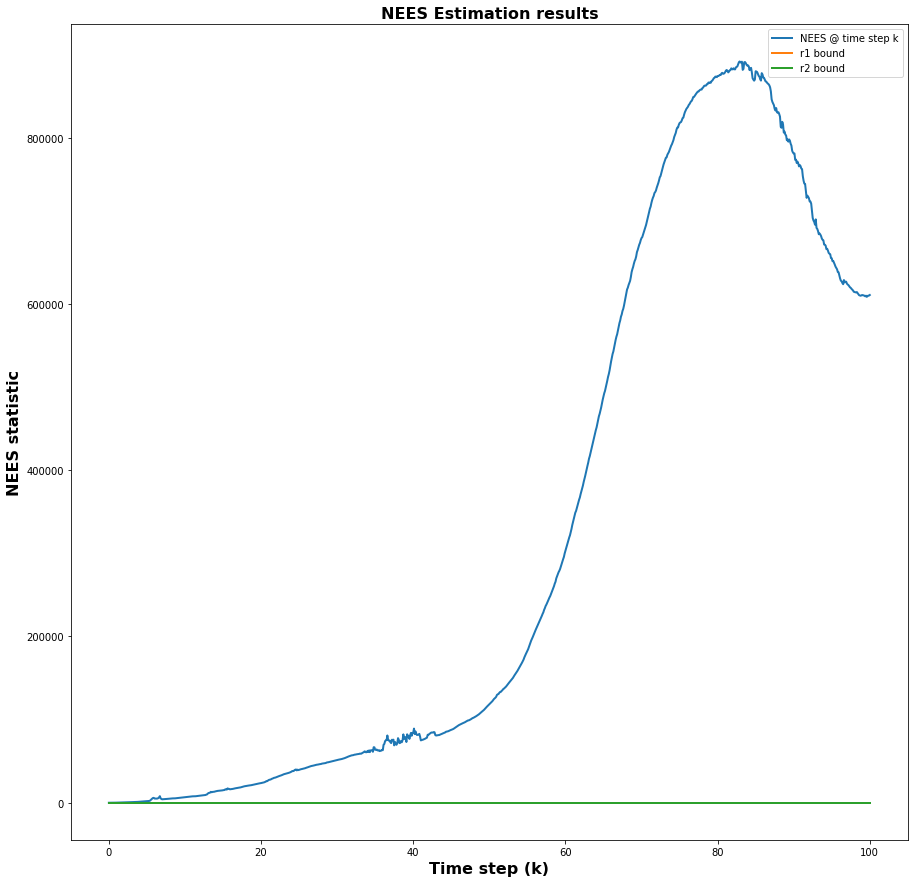

In [216]:
NEES_mean_list = NEES_data.mean(axis=0)
N = num_mc_simulations
n = len(x0)
r1 = chi2.ppf(0.025, df=N*n)/N
r2 = chi2.ppf(0.975, df=N*n)/N

#plt.plot(time_steps,NEES_mean_list)
r1_bound = [r1]*len(time_steps)
r2_bound = [r2]*len(time_steps)
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("NEES statistic",fontsize=16, fontweight='bold')
plt.title("NEES Estimation results",fontsize=16, fontweight='bold')
plt.plot(time_steps,NEES_mean_list,linewidth = 2,label = 'NEES @ time step k')
plt.plot(time_steps,r1_bound,linewidth = 2,label = 'r1 bound')
plt.plot(time_steps,r2_bound,linewidth = 2,label = 'r2 bound')
plt.legend()

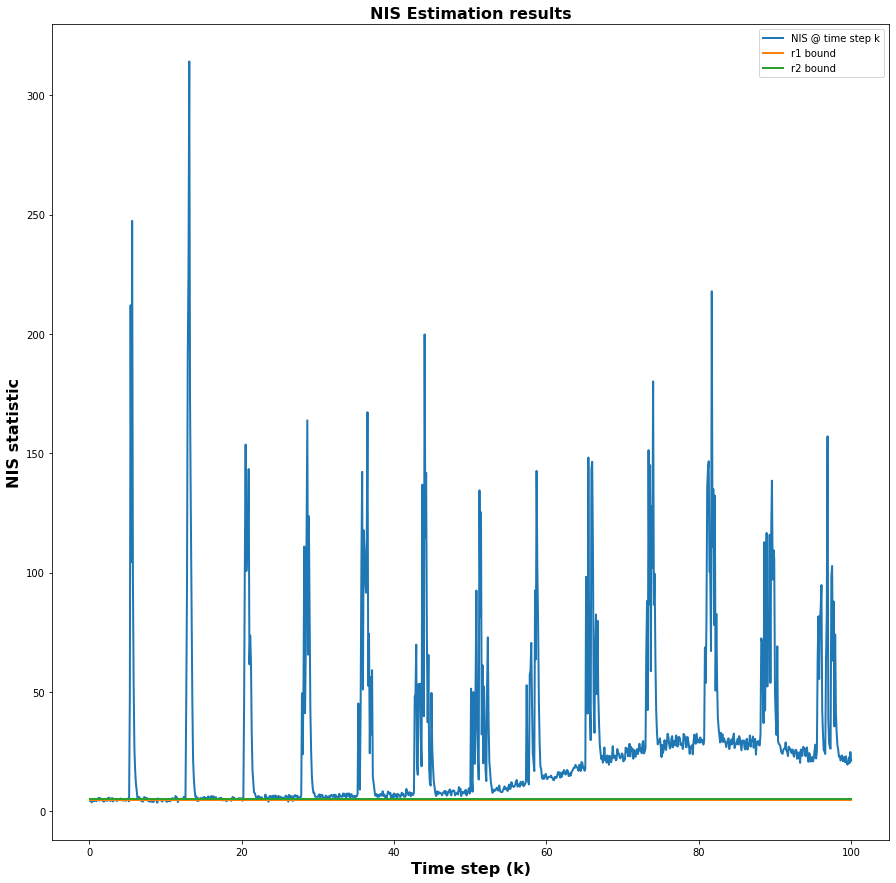

In [217]:
NIS_mean_list = NIS_data.mean(axis=0)
N = num_mc_simulations
p = len(Rtrue)
r1 = chi2.ppf(0.025, df=N*p)/N
r2 = chi2.ppf(0.975, df=N*p)/N

#plt.plot(time_steps,NEES_mean_list)
r1_bound = [r1]*len(time_steps[1:])
r2_bound = [r2]*len(time_steps[1:])
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("NIS statistic",fontsize=16, fontweight='bold')
plt.title("NIS Estimation results",fontsize=16, fontweight='bold')
plt.plot(time_steps[1:],NIS_mean_list,linewidth = 2,label = 'NIS @ time step k')
plt.plot(time_steps[1:],r1_bound,linewidth = 2,label = 'r1 bound')
plt.plot(time_steps[1:],r2_bound,linewidth = 2,label = 'r2 bound')
plt.legend()

In [185]:
# Xtrue = get_Xtrue(x0,time_steps,cholesky_decomposition_Qtrue,L)
# Ytrue = get_Ytrue(Xtrue,cholesky_decomposition_Rtrue)

# estimated_state_list,estimated_covariance_matrix_list,\
# estimated_measurement_list,innovation_covariance_matrix_list = get_estimated_states_and_measurements(x0, Qtrue, u, Ytrue, Qtrue, Rtrue)

# epsilon_x_for_all_time_steps_in_one_simulation = \
# get_epsilon_x_for_all_time_steps_in_one_simulation(Xtrue,estimated_state_list,estimated_covariance_matrix_list)

# epsilon_y_for_all_time_steps_in_one_simulation = get_epsilon_y_for_all_time_steps_in_one_simulation \
# (Ytrue[1:],estimated_measurement_list, innovation_covariance_matrix_list)

# get_weighted_error_x_at_step_k(Xtrue[10],estimated_state_list[10],estimated_covariance_matrix_list[10])

# get_epsilon_x_for_all_time_steps_in_one_simulation(Xtrue,estimated_state_list,estimated_covariance_matrix_list)

# get_epsilon_y_for_all_time_steps_in_one_simulation(Ytrue[1:], estimated_measurement_list, innovation_covariance_matrix_list )

In [96]:
0.05/2

0.025

In [139]:
len(Rtrue)

5

In [181]:
7*10**-1

0.7000000000000001